<a href="https://colab.research.google.com/github/simon-m-mudd/random_fun_notebooks/blob/main/zwift_route_plotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zwift route planner

First, just run the next three cells. This downloads all the routes.

*If you are new to this just click on a cell and hit shift-enter to run*

*If you hover over a cell and see a little play icon, that means it is code that can run. If you don't see the play icon that is text and doesn't run. For example this cell is text but the next cell is code.*

In [22]:
# --- 0) System prep (Node/npm; often already present on Colab) ---
!node -v >/dev/null 2>&1 || (sudo apt-get update -y && sudo apt-get install -y nodejs npm)

In [5]:
# --- 1) Non-interactive GPX download for ALL Zwift routes ---
# Two equivalent ways to skip the "Ok to proceed?" prompt:
#   A) Use the --yes / -y flag:
!npx --yes zwift-tracks-dl
#   B) OR set env var (works across npm 6/7/8): npm_config_yes=true npx zwift-tracks-dl
# If you prefer the env var method, comment the previous line and uncomment below:
# !npm_config_yes=true npx zwift-tracks-dl

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙Total tracks generated: 330
Routes generated: 259
Segments generated: 71
⠙

In [6]:
# --- 2) Inspect what we got ---
import os, glob, textwrap
gpx_dir = os.getcwd()  # downloader writes into CWD or a subfolder; adjust if needed.
gpx_files = sorted(glob.glob("**/*.gpx", recursive=True))
print(f"Found {len(gpx_files)} GPX files.")
for f in gpx_files[:25]:
    print(" -", f)

Found 330 GPX files.
 - tracks/routes/zwift-bologna-time-trial-8.05km-20560239.gpx
 - tracks/routes/zwift-crit-city-bell-lap-1.967km-22419554.gpx
 - tracks/routes/zwift-crit-city-downtown-dolphin-1.962km-22445564.gpx
 - tracks/routes/zwift-france-bon-voyage-28.208km-39240977.gpx
 - tracks/routes/zwift-france-casse-pattes-22.89km-24674909.gpx
 - tracks/routes/zwift-france-croissant-9.273km-39270805.gpx
 - tracks/routes/zwift-france-douce-france-24.004km-24676071.gpx
 - tracks/routes/zwift-france-france-classic-fondo-145.444km-33955609.gpx
 - tracks/routes/zwift-france-gentil-8-23.18km-38856602.gpx
 - tracks/routes/zwift-france-hell-of-the-north-19.816km-38859707.gpx
 - tracks/routes/zwift-france-knights-of-the-roundabout-51.189km-38859646.gpx
 - tracks/routes/zwift-france-la-reine-22.456km-24698649.gpx
 - tracks/routes/zwift-france-macaron-2.436km-38876339.gpx
 - tracks/routes/zwift-france-petit-boucle-60.785km-24676054.gpx
 - tracks/routes/zwift-france-petite-douleur-13.901km-24984611.

## Now, select a route

In the code block below, modify the route name. If the route name is more than one word, use dashes in betweeen the words.

In [9]:
# --- 3) Choose a route GPX by name (edit this to your target route) ---
# Example: try a file whose name includes 'rising-empire'.
target = None
for f in gpx_files:
    if "rising-empire" in os.path.basename(f):
        target = f
        break
if not target and gpx_files:
    target = gpx_files[0]  # fallback
print("Using GPX:", target)

Using GPX: tracks/routes/zwift-new-york-rising-empire-20.816km-19171748.gpx


## Here is all the fancy code

Don't modify anything in the next code block

In [14]:
# --- Elevation + Gradient (both filled, categorical colors, legend below, windowing, PNG save) ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator, FuncFormatter

def _zwift_binned_palette():
    """
    Zwift-like categorical bands:
      <0%: blue, 0–3%: green, 3–6%: yellow, 6–9%: orange, ≥9%: red
    """
    bounds = np.array([-np.inf, 0, 3, 6, 9, np.inf], dtype=float)  # %
    colors = ['#4ea3f7',  # <0% (cool blue)
              '#00c853',  # 0–3% (green)
              '#ffd600',  # 3–6% (yellow)
              '#ff8f00',  # 6–9% (orange)
              '#d50000']  # ≥9% (red)
    labels = ['< 0%', '0–3%', '3–6%', '6–9%', '≥ 9%']
    return bounds, colors, labels

def _segment_polys(x, y, base=0.0):
    """Build trapezoids between (x[i],y[i]) and (x[i+1],y[i+1]) relative to a baseline."""
    polys = []
    for i in range(len(x)-1):
        polys.append([(x[i], base), (x[i], y[i]), (x[i+1], y[i+1]), (x[i+1], base)])
    return polys

def _segment_colors_binned(g, bounds, colors):
    seg_colors = []
    for i in range(len(g)-1):
        gi = 0.5*(g[i] + g[i+1])  # average segment gradient
        idx = np.digitize([gi], bounds)[0]-1
        idx = max(0, min(idx, len(colors)-1))
        seg_colors.append(colors[idx])
    return seg_colors

def plot_profile_and_gradient_categorised(
    dists, elevs, grads,
    start_km=None, end_km=None,     # distance window (km)
    rebase_distance=True,           # zero km at window start
    title=None,
    save_png=None, dpi=200          # PNG export options
):
    """
    Two-row figure:
      • Top: ELEVATION (filled to zero), fill colored by categorical gradient
      • Bottom: GRADIENT (filled to zero), same categorical colors + dashed 3% line
    Gradient key is placed BELOW the figure so both subplots have equal width.
    """
    # --- Prepare arrays ---
    x_full = np.asarray(dists)/1000.0
    y_full = np.asarray(elevs, dtype=float)
    g_full = np.asarray(grads, dtype=float)

    # --- Windowing ---
    if start_km is None: start_km = float(x_full[0])
    if end_km   is None: end_km   = float(x_full[-1])
    if end_km <= start_km:
        raise ValueError("end_km must be greater than start_km")

    m = (x_full >= start_km) & (x_full <= end_km)
    if m.sum() < 2:
        i0 = int(np.searchsorted(x_full, start_km, side='left'))
        i1 = int(np.searchsorted(x_full, end_km,   side='right'))
        i0 = max(0, min(i0, len(x_full)-2))
        i1 = max(i0+1, min(i1, len(x_full)))
        sl = slice(i0, i1)
    else:
        idx = np.where(m)[0]
        sl = slice(idx[0], idx[-1]+1)

    x = x_full[sl].copy()
    y = y_full[sl].copy()
    g = g_full[sl].copy()

    if rebase_distance:
        x -= x[0]

    # --- Colors (categorical) ---
    bounds, bin_colors, labels = _zwift_binned_palette()
    seg_cols = _segment_colors_binned(g, bounds, bin_colors)

    # --- Polygons for both plots ---
    polys_elev = _segment_polys(x, y, base=0.0)
    polys_grad = _segment_polys(x, g, base=0.0)

    # --- Figure: 2 rows, 1 column, height ratio 2:1; legend below (outside axes) ---
    fig = plt.figure(figsize=(11.8, 6.4))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.07)
    ax1 = fig.add_subplot(gs[0, 0])        # Elevation
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Gradient

    # Elevation (top)
    coll1 = PolyCollection(polys_elev, facecolors=seg_cols, edgecolors='none', antialiased=False)
    ax1.add_collection(coll1)
    ax1.plot(x, y, color='k', lw=1.2)  # roofline
    ax1.set_xlim(x.min(), x.max())
    ax1.set_ylim(0, max(5, y.max()*1.05))
    ax1.set_ylabel("Elevation (m)")
    ax1.grid(alpha=0.25, linestyle='--', axis='y')

    # Gradient (bottom)
    coll2 = PolyCollection(polys_grad, facecolors=seg_cols, edgecolors='none', antialiased=False)
    ax2.add_collection(coll2)
    ax2.axhline(0, color='k', lw=0.8, alpha=0.7)
    # 3% threshold
    ax2.axhline(3, color='k', lw=1.0, alpha=0.8, linestyle='--')
    # symmetric y-limits for clarity
    g_abs = np.nanmax(np.abs(g)) if np.isfinite(g).any() else 10.0
    g_lim = max(3.0, np.ceil(g_abs/1.0)*1.0)
    ax2.set_ylim(-g_lim, g_lim)
    ax2.set_xlabel("Distance (km)")
    ax2.set_ylabel("Grade (%)")
    ax2.grid(alpha=0.25, linestyle='--', axis='y')

    # Avoid overlapping x tick labels: show ticks only on bottom; limit number and format
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))  # reduce tick crowding
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.1f}"))

    # Title (on top axis)
    if title is None:
        try:
            import os
            title = os.path.basename(target)
        except Exception:
            title = "Zwift Route"
    ax1.set_title(f"{title} — elevation & gradient (categorised fill)")

    # --- Figure-level legend (below), so subplot widths remain identical ---
    legend_patches = [
        Patch(facecolor=bin_colors[0], label=labels[0]),
        Patch(facecolor=bin_colors[1], label=labels[1]),
        Patch(facecolor=bin_colors[2], label=labels[2]),
        Patch(facecolor=bin_colors[3], label=labels[3]),
        Patch(facecolor=bin_colors[4], label=labels[4]),
    ]
    # Add extra bottom margin to make space for the legend
    fig.subplots_adjust(bottom=0.20)
    # Place legend centered at the bottom OUTSIDE the axes
    fig.legend(handles=legend_patches, loc='lower center',
               ncol=len(legend_patches), frameon=True, fontsize=9,
               bbox_to_anchor=(0.5, 0.04))  # adjust vertical anchor as needed

    # Optional PNG export
    if isinstance(save_png, str) and save_png.strip():
        fig.savefig(save_png, dpi=dpi, bbox_inches='tight')
        print(f"Saved figure to: {save_png}")

    plt.show()
    return fig, (ax1, ax2)

## Plot the full route!

You can plot the full route here. use the `save_png` option to change the filename.

Saved figure to: route_profile_categorised.png


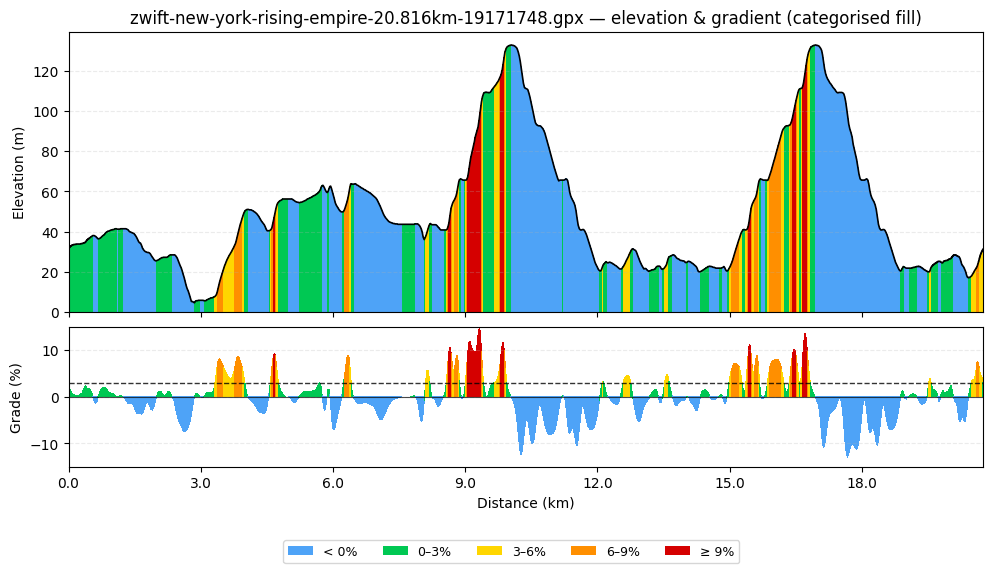

In [21]:
# Full route, rebased distance (0 at start), save as PNG
fig, (ax1, ax2) = plot_profile_and_gradient_categorised(
    dists, elevs, grads,
    start_km=None, end_km=None,
    rebase_distance=True,
    title=os.path.basename(target),
    save_png="route_profile_categorised.png",
    dpi=220
)

## Now plot a small section!

This plots a small section, you can update the `start_km` and the `end_km`, and then use the `title` and `save_png` to update the title of the plot and the output file.

Saved figure to: route_section_3to4.5km_categorised.png


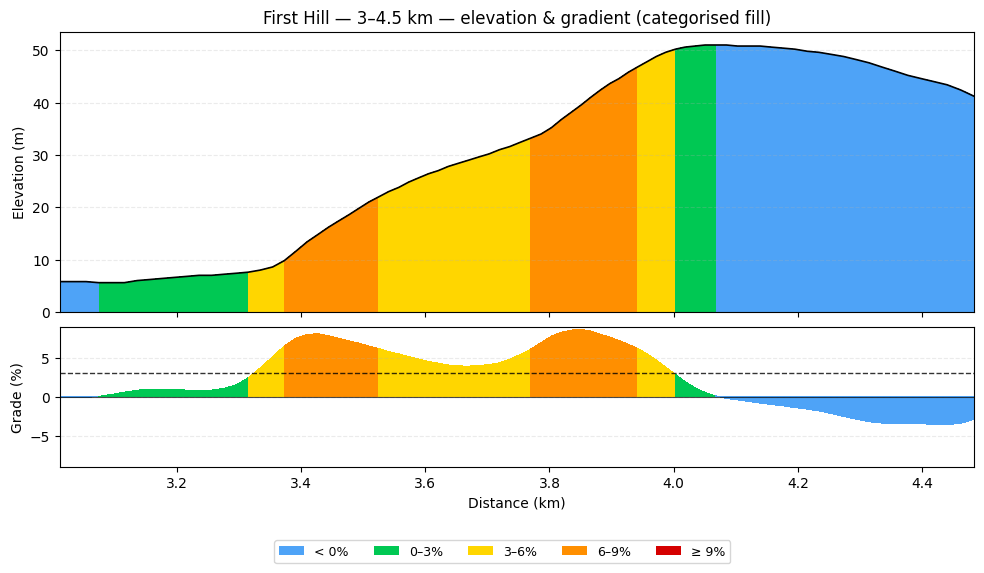

In [18]:
# Zoom into a section (e.g., 5–18 km), keep absolute km (no rebase), and save
fig, (ax1, ax2) = plot_profile_and_gradient_categorised(
    dists, elevs, grads,
    start_km=3, end_km=4.5,
    rebase_distance=False,
    title=f"First Hill — 3–4.5 km",
    save_png="route_section_3to4.5km_categorised.png",
    dpi=220
)